In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
!pip install torch torchvision

In [16]:
import numpy as np
import pandas as pd
import torch

In [17]:
import torchvision
import matplotlib.pyplot as plt
from PIL import Image , ImageDraw
from sklearn.model_selection import train_test_split

In [18]:
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [19]:
path = '/kaggle/input/globalwheatdetectionextend/train.csv'

In [20]:
train = pd.read_csv(path)

In [21]:
train.head()

image_id  width  height                 bbox      source
0   1011_0   1024    1024  [155, 500, 113, 68]  extend_set
1   1011_0   1024    1024  [218, 552, 125, 89]  extend_set
2   1011_0   1024    1024  [352, 547, 95, 110]  extend_set
3   1011_0   1024    1024   [543, 536, 48, 88]  extend_set
4   1011_0   1024    1024   [653, 535, 68, 64]  extend_set

In [48]:
def finding(text):
    ar = text.split(',')
    ar[0] = ar[0][1:]
    ar[-1] = ar[-1][:-1]
    ar = np.array(list(map(int , ar)))
    return ar 

In [52]:
ar = train['bbox'].apply(finding).values

In [57]:
x1 = []
y1 = []
W = []
H = []

for i in ar:
    x , y , w , h = i 
    x1.append(x)
    y1.append(y)
    W.append(w)
    H.append(h)

In [58]:
train['x1'] = x1 
train['y1'] = y1 
train['W'] = W
train['H'] = H 

In [59]:
train.head()

image_id  width  height                 bbox      source   x1   y1    W    H
0   1011_0   1024    1024  [155, 500, 113, 68]  extend_set  155  500  113   68
1   1011_0   1024    1024  [218, 552, 125, 89]  extend_set  218  552  125   89
2   1011_0   1024    1024  [352, 547, 95, 110]  extend_set  352  547   95  110
3   1011_0   1024    1024   [543, 536, 48, 88]  extend_set  543  536   48   88
4   1011_0   1024    1024   [653, 535, 68, 64]  extend_set  653  535   68   64

In [60]:
train.drop(columns = ['width' , 'height','bbox','source'] , inplace = True)

In [61]:
train.head()

image_id   x1   y1    W    H
0   1011_0  155  500  113   68
1   1011_0  218  552  125   89
2   1011_0  352  547   95  110
3   1011_0  543  536   48   88
4   1011_0  653  535   68   64

In [63]:
unique_images = train['image_id'].unique()

In [95]:
class CustData(torch.utils.data.Dataset):
    def __init__(self, df, unique_images, indices):
        self.df = df 
        self.unique_images = unique_images 
        self.indices = indices 

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image_name = self.unique_images[self.indices[idx]] 
        
        # Extract the rows corresponding to the image
        image_data = self.df[self.df['image_id'] == image_name]

        # Convert from (x1, y1, W, H) to (x_min, y_min, x_max, y_max)
        boxes = image_data[['x1', 'y1', 'W', 'H']].values
        boxes = np.stack([boxes[:, 0],  # x1 (x_min)
                          boxes[:, 1],  # y1 (y_min)
                          boxes[:, 0] + boxes[:, 2],  # x1 + W (x_max)
                          boxes[:, 1] + boxes[:, 3]], # y1 + H (y_max)
                          axis=1).astype('float32')
        
        # Load the image
        img = Image.open('/kaggle/input/globalwheatdetectionextend/train/' + image_name + '.jpg').convert('RGB')
        
        # Create labels (you can adjust this depending on your actual labels)
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)
        
        # Create target dictionary
        target = {} 
        target['boxes'] = torch.tensor(boxes, dtype=torch.float32)  # Ensure the boxes are of the right type
        target['labels'] = labels 
        
        # Return the image and target
        return T.ToTensor()(img), target

def custom_collate(data):
    return data

In [96]:
train_ind , val_ind = train_test_split(range(unique_images.shape[0]),test_size = 0.1)

In [97]:
train_d = torch.utils.data.DataLoader(
    CustData(train, unique_images, train_ind), 
    batch_size=16, 
    shuffle=True, 
    collate_fn=custom_collate, 
    pin_memory=True if torch.cuda.is_available() else False
)

val_d = torch.utils.data.DataLoader(
    CustData(train, unique_images, val_ind), 
    batch_size=16, 
    shuffle=True, 
    collate_fn=custom_collate, 
    pin_memory=True if torch.cuda.is_available() else False
)


In [98]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = True)

In [99]:
num_classes = 2 

In [100]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [101]:
in_features = model.roi_heads.box_predictor.cls_score.in_features 

In [102]:
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , num_classes)

In [103]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [104]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [105]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [80]:
opt = torch.optim.SGD(model.parameters() , lr = 0.1 , momentum = 0.9, weight_decay = 0.005)

In [81]:
num_epochs = 5

In [107]:
for epoch in range(num_epochs):
    model.train()  # Ensure model is in training mode
    epoch_loss = 0 
    for data in train_d:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ['boxes'] = d[1]['boxes'].to(device)
            targ['labels'] = d[1]['labels'].to(device)
            targets.append(targ)
        
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())

        epoch_loss += loss.item()  # Use .item() instead of cpu().detach().numpy() for a scalar value

        opt.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagate loss
        opt.step()  # Update parameters

    # Optionally log the epoch loss here
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}')

Epoch 1/5, Loss: 430.5725464820862
Epoch 2/5, Loss: 430.91279649734497
Epoch 3/5, Loss: 430.93184423446655
Epoch 4/5, Loss: 430.43206119537354
Epoch 5/5, Loss: 431.01139211654663


In [110]:
train.head()

image_id   x1   y1    W    H
0   1011_0  155  500  113   68
1   1011_0  218  552  125   89
2   1011_0  352  547   95  110
3   1011_0  543  536   48   88
4   1011_0  653  535   68   64

In [111]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [112]:
data = iter(val_d).__next__()

In [126]:
img = data[0][0]

In [121]:
boxes = data[0][1]['boxes']

In [123]:
labels = data[0][1]['labels']

In [127]:
output = model([img.to(device)])

In [133]:
output

[{'boxes': tensor([[ 319.7520,  638.9677,  338.9838,  656.8881],
          [ 128.0810,  501.8321,  158.4421,  526.0833],
          [  88.1400,  644.2573,  112.9779,  678.6588],
          [ 133.9167,  492.4220,  154.1593,  520.8898],
          [ 393.3788,  518.9389,  408.5240,  545.9375],
          [ 636.9429,  314.0922,  662.6711,  368.2125],
          [ 325.5038,  636.2750,  344.2146,  654.7207],
          [ 363.3163,  665.0951,  447.4198,  734.8655],
          [  70.0815,  169.1686,   96.0832,  204.3586],
          [ 313.1945,  637.9576,  331.3915,  653.9518],
          [ 328.3680,  640.6186,  349.0149,  659.4690],
          [  50.3454,  483.5696,   76.8459,  511.7939],
          [ 628.9294,  308.0914,  666.8798,  353.0335],
          [ 639.9103,  310.4691,  662.4354,  329.5545],
          [ 999.5232,  741.1075, 1024.0000,  776.9688],
          [ 469.7180,  681.1219, 1024.0000,  941.3424],
          [ 316.7735,  634.6522,  353.5116,  667.6033],
          [   0.0000,  700.3918, 1024.0

In [134]:
out_bboxes = output[0]['boxes']
out_scores = output[0]['scores']

In [135]:
req = torchvision.ops.nms(out_bboxes , out_scores , 0.45)

In [138]:
out_bboxes.shape

torch.Size([100, 4])

In [139]:
req.shape

torch.Size([87])

In [141]:
im = (img.permute(1,2,0).cpu().detach().numpy()*255)

In [144]:
im = im.astype('uint8')

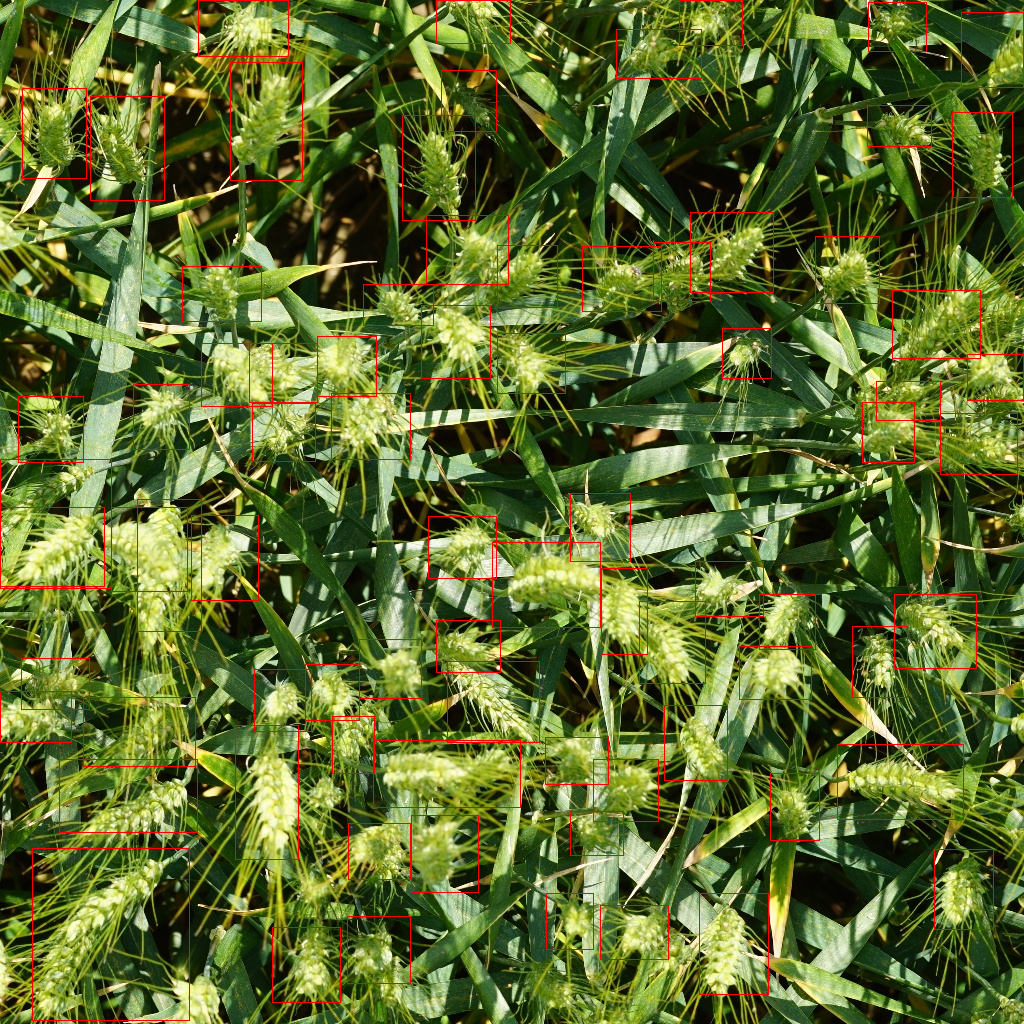

In [148]:
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes:
    draw.rectangle(list(box) , fill = None , outline = 'red')
vsample

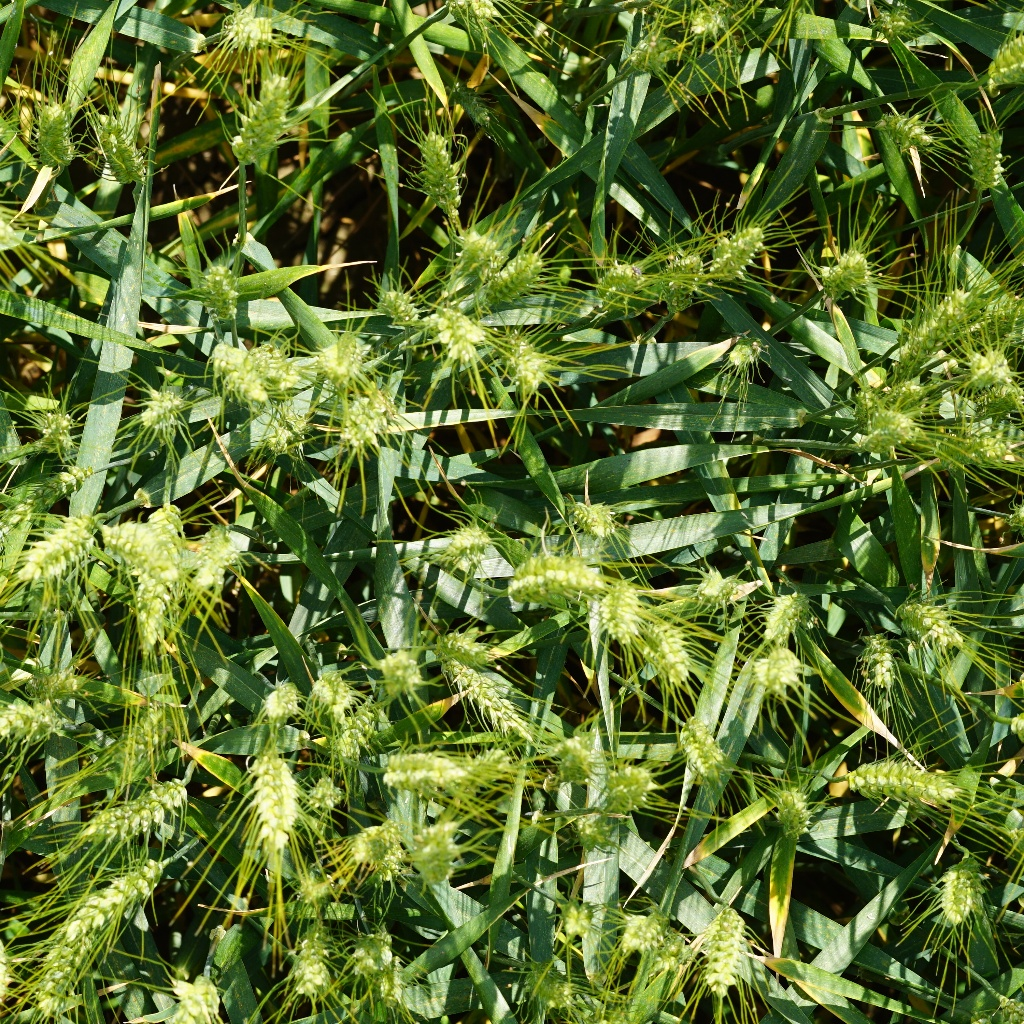

In [170]:
vsample1 = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in actbx:
    draw.rectangle(list(box) , fill = None , outline = 'red')
vsample1

In [165]:
actbx = []
for i in req:
    actbx.append(out_bboxes[i])

In [171]:
torch.save(model.state_dict() , 'modified_fasterrcnn_fpn.pth')

In [172]:
## Loading The Saved Model

In [173]:
import torch

In [178]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features , num_classes)
    return model

In [179]:
model2 = create_model(2)

In [180]:
model2.load_state_dict(torch.load('/kaggle/working/modified_fasterrcnn_fpn.pth'))

/tmp/ipykernel_36/936789569.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('/kaggle/working/modified_fasterrcnn_fpn.pth'))


<All keys matched successfully>

In [181]:
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu